## SPUR Densification Survey- NLP Sentiment Analysis
author: Emily Robitschek

### Background information on survey: 
This survey was conducted by the SPUR group at ETH: https://spur.ethz.ch/
-(add more info)

### Hypothesis/Research question: 
Can we use the open text field responses from densification surveys to infer something about the motivations and emotions behind why individuals responded the way they did to the densification survey?

In [1]:
## Package imports
import os
import glob
import time

import scipy
import numpy as np
import pandas as pd

#set up packages for processing data types and for NLP analysis
from collections import OrderedDict
import contractions
import spacy
nlp=spacy.load('en_core_web_sm') #or the multi-language one: spacy.load('xx_ent_wiki_sm')

#graphing/visualization packages: 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
## Helper functions

def filter_response_df(response_df, open_text_column, min_char=0):
    """
    Takes in a dataframe for survey responses (response_df) and the column with the open text field of 
    interest (open_text_column) and a minimum character limit (automatically set at zero for no filtering) 
    and returns a dataframe with the null responses for that column filtered out and if min_char > 0, also 
    filters out responses shorter than or equal to the min_char limit.
    """
    #filter na responses
    response_df = response_df.dropna(subset=[open_text_column])
    #calculate character lengths of all non-NA responses
    response_char_length = []
    for i in range(0, len(response_df)):
        char_length = len(response_df[open_text_column][i])
        #if char_length < 10: ## if want to look at some of the responses for short character lengths
        #    print(response_df[open_text_column][i])
            #print(char_length)
        response_char_length.append(char_length)
    response_df['response_char_length'] = response_char_length
    if min_char > 0: 
        return response_df[response_df['response_char_length'] > min_char].copy()
    else: 
        return response_df

In [3]:
## Read in data
survey_responses_filepath = '../../../data/Densification_Survey/Chicago_original.csv' #lets work with the data from Chicago first
survey_response_df = pd.read_csv(survey_responses_filepath)
survey_response_df.head()

/Users/emilyrobitschek/opt/anaconda3/envs/giz_nlp_env_v1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,5,9,10,11,12,13,14,17,18,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,36,37,38,39,41,42,43,44,47,48,49,50,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,69,70,71,72,75,76,77,78,80,81,82,83,86,87,88,89,91,92,93,94,99,100,101,102,113,114,115,116,123,124,125,126,134,135,136,137,142,143,144,145,150,151,152,153,162,163,164,165,166,167,168,169,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,191,192,193,194,198,199,200,201,205,206,207,208,212,213,214,215,219,220,221,222,224,225,226,227,228,229,230,231,232,233,234,237,238,239,240,242,243,244,245,248,249,250,251,253,254,255,256,257,259,260,261,262,263,265,266,267,268,270,271,272,273,275,276,277,278,279,282,283,284,285,287,288,289,290,291,292,293,294,295,296,298,299,300,301,302,303,304,305,306,308,309,310,311,313,314,315,316,318,319,320,321,324,325,326,327,329,330,331,332,334,335,336,337,3

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,cintid,ProjectToken,pid,psid,basic,gc,term,age,projectLocation,LS
0,Anfangsdatum,Enddatum,Antworttyp,IP-Adresse,Aktueller Stand,Dauer (in Sekunden),Beendet,Erfassungsdatum,Antwort-ID,Nachname des Empfängers,...,cintid,ProjectToken,pid,psid,basic,gc,term,age,projectLocation,LS
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}",...,"{""ImportId"":""cintid""}","{""ImportId"":""ProjectToken""}","{""ImportId"":""pid""}","{""ImportId"":""psid""}","{""ImportId"":""basic""}","{""ImportId"":""gc""}","{""ImportId"":""term""}","{""ImportId"":""age""}","{""ImportId"":""projectLocation""}","{""ImportId"":""LS""}"
2,2021-02-18 05:46:05,2021-02-18 05:59:36,IP-Adresse,172.221.89.193,100,810,Richtig,2021-02-18 05:59:39,R_2dAqH8oUCTPTMfN,NaN,...,NaN,NaN,NaN,NaN,23350,1,NaN,25-34,Southwest Side,{Invalid Expression}
3,2021-02-18 06:05:55,2021-02-18 06:11:22,IP-Adresse,76.236.119.37,100,327,Richtig,2021-02-18 06:11:23,R_2X1HpxcUtZEpWYk,NaN,...,NaN,NaN,NaN,NaN,23350,1,NaN,25-34,Far Southwest Side,{Invalid Expression}
4,2021-02-18 06:18:04,2021-02-18 06:23:04,IP-Adresse,73.111.29.206,100,300,Richtig,2021-02-18 06:23:05,R_10PI5FKTTlId8Ec,NaN,...,NaN,NaN,NaN,NaN,23350,1,NaN,18-24,South Side,{Invalid Expression}


We can immediately see that the first two rows after the header include the column names in German and then the importids. I will skip these first two rows, which also fixes most of the "mixed data types" errors for the columns.

In [4]:
#load dataframe without rows 1 and 2 
survey_response_df = pd.read_csv(survey_responses_filepath, skiprows=[1,2])
survey_response_df.head()

#examine column names for clues as to where the open text field columns might be: 
list(survey_response_df.columns)
survey_response_df.iloc[:, 220:]

#make sure that column 'Q12.6' is formatted as a string
survey_response_df['Q12.6'] = survey_response_df['Q12.6'].astype(str)

/Users/emilyrobitschek/opt/anaconda3/envs/giz_nlp_env_v1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (253,259,275,375,503) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
## Explore data and find open text field section
survey_text_answered = survey_response_df.dropna(subset=['Q12.6'])
survey_text_answered.head()
print(len(survey_text_answered))
for i in range(0, len(survey_text_answered)):
    print(survey_text_answered['Q12.6'][i])

3416
Great deal
Goo
I’m not yo I’m not talking to you 
It is the way it is
Because it would be more far to people that don't have much
I choose proposal 2 because you offered me better things than proposal 1. 
Mhmmm girl
Because I felt like it wouldn’t be good enough for us 
I don't know
no comment
nothing 
yes
Ttyh
agree stong
Nothing to say 
I I prefer the lower density idea, but also mixed use with restaurants, cafes,etc. because I think it would draw other people from the surrounding communities more often as opposed to crafts or just apartments. Would also be more beneficial to residents of that neighborhood.
Not sure 
Yes
Whatever one sounds better
My positions are better 
This is Good Survey.
I don’t want the density to double!!
Yo yo bro I don’t know why 
Too many legalities
I like it 
Generally, I didn't agree with the subsidized housing issue.
Yes I love you too and miss you
Had to pick one
Because some are great
None
It's only logical to go by the decisios I made based on wh

The mayor is a disgrace 
None
Some proposals had more to offer the community 
I do not like any of the proposals.  Find another neighborhood to build these projects in.
I prefer projeci that have some affordable housing and a mixture of residential and business, more diversity and vitality
small increase in density and mixed use
Na
Investors and perks pros cons of both 
Ideally I would like to see a cap of no more than 5% increase, no government funding, a mix of apartments and small businesses, 20% diversification, resident's input/updates, plus some kind of beautification project such as a park. What was proposed here did not include all of these in just one proposal.
I think that my current neighborhood could adequately cope with the changes of the various proposals without too much strain or stress.
good
nan
nan
the proposals seem promising
Do not want government control or international for profit. Not pop increase >20%
nan
nan
nan
nan
I worry about any proposals that make no comm

### Intitial thoughts (Oct. 14, 2021)
Based on the responses, I am seeing several things: 

1) The response length varies greatly, with shorter responses more often (but not always) being "throw away" responses that are: 
>Either somewhat random (e.g. "Fyfgfx" or "Bzsbsnsbsn") or 
>unrelated to the survey or displaying a sort of apathetic/lackadiasical attitude (or maybe they were just tired of filling out the survey at that point - hard to say haha. (e.g. "Idk", "Nope", "Favor", "Nigh", "40", "I’m not yo I’m not talking to you"). 

However, the fact there are these patterns might be informative in and of themselves if they relate reliably to certain survey responses. (They also speak to core issues potentially like lack of trust or lack of knowledge, although they are confounded/hard to infer motivations behind them).

2) Even in substantive responses, the spelling isnt necessarily great so we should keep that in mind. 
>(e.g. "Because it would be more far to people that don't have much") - this person clearly meant "fair" not "far". or "I think the 10 percent is to high of a yearly increase" - this person clearly meant "too" not "to"

3) This is going to be hard/may not pull out anything reliably interesting 

4) May be interesting to see if response patterns map to particular neighborhoods

### Data exploration: Lengths of responses

There are 3416 non null entries for the text field in this dataset


Text(0.5, 1.0, 'Distribution of character length of short-response for survey for Chicago')

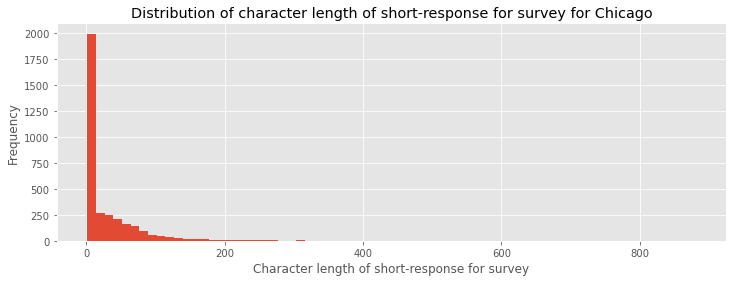

In [6]:
response_df = filter_response_df(survey_response_df, 'Q12.6', min_char=0)   
print("There are %d non null entries for the text field in this dataset" % (len(response_df)))
response_df['response_char_length'].head()

## Plot distribution of length of responses
plt.rcParams["figure.figsize"] = (12,4)
#sns.set(rc={'figure.figsize':(8,3)})
plt.hist(x=response_df['response_char_length'], bins=70)
plt.xlabel("Character length of short-response for survey")
plt.ylabel("Frequency")
title = ("Distribution of character length of short-response for survey for Chicago")
plt.title(title)

There are 1512 non null entries for the text field in this dataset


Text(0.5, 1.0, 'Distribution of character length of short-response for survey for Chicago')

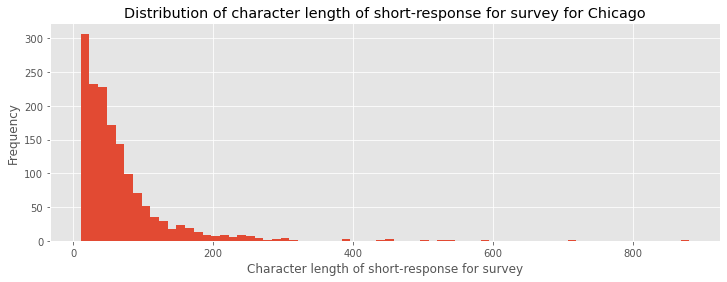

In [7]:
# cut out short responses for now (<10 maybe? or <20, although some have some interesting words like rent or no or yes or good)
response_df = filter_response_df(survey_response_df, 'Q12.6', min_char=10)   
print("There are %d non null entries for the text field in this dataset" % (len(response_df)))
response_df['response_char_length'].head()

## Plot distribution of length of responses
plt.rcParams["figure.figsize"] = (12,4)
#sns.set(rc={'figure.figsize':(8,3)})
plt.hist(x=response_df['response_char_length'], bins=70)
plt.xlabel("Character length of short-response for survey")
plt.ylabel("Frequency")
title = ("Distribution of character length of short-response for survey for Chicago")
plt.title(title)

In [8]:
## Preprocess data

In [9]:
## Hugging Face? 

In [10]:
## Sentiment analysis

In [11]:
## Topic analysis

In [12]:
## Mapping preferences in the different cities
#https://plotly.com/python/choropleth-maps/